## Import libraries

In [ ]:
import warnings
warnings.filterwarnings("ignore")

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score,precision_recall_fscore_support
from sklearn.metrics import f1_score,roc_auc_score
from sklearn.ensemble import RandomForestClassifier,ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier
import xgboost as xgb
from xgboost import plot_importance

In [ ]:
df = pd.read_csv('CICIDS2017_sample.csv') 

In [ ]:
df

,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,Bwd Packet Length Max,...,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,4,2,0,37,0,31,6,18.500000,17.677670,0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
1,142377,46,62,1325,105855,570,0,28.804348,111.407285,4344,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
2,118873,23,28,1169,45025,570,0,50.826087,156.137367,2896,...,32,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
3,143577,43,55,1301,107289,570,0,30.255814,115.178969,4344,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
4,143745,49,59,1331,110185,570,0,27.163265,108.067176,4344,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56656,234,2,2,64,232,32,32,32.000000,0.000000,116,...,32,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
56657,133288,2,2,94,482,47,47,47.000000,0.000000,241,...,32,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
56658,11507694,5,4,450,3525,450,0,90.000000,201.246118,3525,...,32,893.0,0.0,893,893,6503640.0,0.0,6503640,6503640,DoS
56659,11507707,8,6,416,11632,416,0,52.000000,147.078211,5792,...,32,897.0,0.0,897,897,6503122.0,0.0,6503122,6503122,DoS


In [ ]:
df.Label.value_counts()

BENIGN          22731
DoS             19035
PortScan         7946
BruteForce       2767
WebAttack        2180
Bot              1966
Infiltration       36
Name: Label, dtype: int64

### Preprocessing (normalization and padding values)

In [ ]:
# Z-score normalization
features = df.dtypes[df.dtypes != 'object'].index
df[features] = df[features].apply(
    lambda x: (x - x.mean()) / (x.std()))
# Fill empty values by 0
df = df.fillna(0)

### Data sampling


In [ ]:
labelencoder = LabelEncoder()
df.iloc[:, -1] = labelencoder.fit_transform(df.iloc[:, -1])

In [ ]:
df.Label.value_counts()

0    22731
3    19035
5     7946
2     2767
6     2180
1     1966
4       36
Name: Label, dtype: int64

In [ ]:
# retain the minority class instances and sample the majority class instances
df_minor = df[(df['Label']==6)|(df['Label']==1)|(df['Label']==4)]
df_major = df.drop(df_minor.index)

In [ ]:
X = df_major.drop(['Label'],axis=1) 
y = df_major.iloc[:, -1].values.reshape(-1,1)
y=np.ravel(y)

In [ ]:
# use k-means to cluster the data samples and select a proportion of data from each cluster
from sklearn.cluster import MiniBatchKMeans
kmeans = MiniBatchKMeans(n_clusters=1000, random_state=0).fit(X)

In [ ]:
klabel=kmeans.labels_
df_major['klabel']=klabel

In [ ]:
df_major['klabel'].value_counts()

451    546
613    487
79     369
487    348
257    332
      ... 
776      2
397      2
670      2
12       1
159      1
Name: klabel, Length: 986, dtype: int64

In [ ]:
cols = list(df_major)
cols.insert(78, cols.pop(cols.index('Label')))
df_major = df_major.loc[:, cols]

In [ ]:
df_major

,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,Bwd Packet Length Max,...,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,klabel,Label
0,-0.528470,-0.068426,-0.081806,-0.032573,-0.048343,-0.202326,-0.085798,-0.141625,-0.176448,-0.559719,...,-0.109889,-0.081786,-0.128620,-0.094860,-0.458729,-0.137651,-0.466440,-0.442057,133,0
1,-0.524593,0.704878,0.850340,0.027749,0.920410,0.603275,-0.211174,-0.082434,0.240596,1.006302,...,-0.109889,-0.081786,-0.128620,-0.094860,-0.458729,-0.137651,-0.466440,-0.442057,410,0
2,-0.525233,0.300651,0.339163,0.020443,0.363712,0.603275,-0.211174,0.044064,0.439619,0.484295,...,-0.109889,-0.081786,-0.128620,-0.094860,-0.458729,-0.137651,-0.466440,-0.442057,682,0
3,-0.524560,0.652153,0.745098,0.026625,0.933533,0.603275,-0.211174,-0.074097,0.257378,1.006302,...,-0.109889,-0.081786,-0.128620,-0.094860,-0.458729,-0.137651,-0.466440,-0.442057,410,0
4,-0.524555,0.757604,0.805237,0.028030,0.960037,0.603275,-0.211174,-0.091861,0.225734,1.006302,...,-0.109889,-0.081786,-0.128620,-0.094860,-0.458729,-0.137651,-0.466440,-0.442057,410,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56656,-0.528463,-0.068426,-0.051737,-0.031309,-0.046220,-0.200831,0.457498,-0.064078,-0.255104,-0.517901,...,-0.109889,-0.081786,-0.128620,-0.094860,-0.458729,-0.137651,-0.466440,-0.442057,851,0
56657,-0.524840,-0.068426,-0.051737,-0.029904,-0.043932,-0.178412,0.770939,0.022086,-0.255104,-0.472838,...,-0.109889,-0.081786,-0.128620,-0.094860,-0.458729,-0.137651,-0.466440,-0.442057,976,0
56658,-0.215111,-0.015701,-0.021667,-0.013231,-0.016083,0.423920,-0.211174,0.269089,0.640328,0.711051,...,-0.108682,-0.081786,-0.127669,-0.093554,-0.256386,-0.137651,-0.269448,-0.238252,352,3
56659,-0.215111,0.037025,0.008402,-0.014823,0.058109,0.373103,-0.211174,0.050807,0.399311,1.528310,...,-0.108677,-0.081786,-0.127664,-0.093548,-0.256402,-0.137651,-0.269464,-0.238268,980,3


In [ ]:
def typicalSampling(group):
    name = group.name
    frac = 0.008
    return group.sample(frac=frac)

result = df_major.groupby(
    'klabel', group_keys=False
).apply(typicalSampling)

In [ ]:
result['Label'].value_counts()

0    115
3    106
5     61
2     19
Name: Label, dtype: int64

In [ ]:
result

,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,Bwd Packet Length Max,...,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,klabel,Label
6742,-0.420040,-0.033276,-0.081806,-0.033182,-0.048343,-0.239691,-0.085798,-0.213428,-0.255104,-0.559719,...,-0.109889,-0.081786,-0.128620,-0.094860,-0.458729,-0.137651,-0.466440,-0.442057,2,3
25635,-0.528465,-0.068426,-0.051737,-0.029904,-0.046549,-0.178412,0.770939,0.022086,-0.255104,-0.524390,...,-0.109889,-0.081786,-0.128620,-0.094860,-0.458729,-0.137651,-0.466440,-0.442057,9,0
1429,-0.478649,-0.050851,0.023436,-0.033088,0.057881,-0.218767,-0.211174,-0.198110,-0.209439,1.019281,...,-0.109889,-0.081786,-0.128620,-0.094860,-0.458729,-0.137651,-0.466440,-0.442057,10,3
1479,-0.527750,-0.050851,0.008402,-0.033088,0.057826,-0.218767,-0.211174,-0.198110,-0.209439,1.019281,...,-0.109889,-0.081786,-0.128620,-0.094860,-0.458729,-0.137651,-0.466440,-0.442057,10,3
12024,-0.528468,-0.086001,-0.066771,-0.034306,-0.048288,-0.248659,-0.211174,-0.247894,-0.255104,-0.557556,...,-0.109889,-0.081786,-0.128620,-0.094860,-0.458729,-0.137651,-0.466440,-0.442057,13,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52563,-0.528445,-0.015701,-0.081806,-0.034306,-0.048343,-0.248659,-0.211174,-0.247894,-0.255104,-0.559719,...,-0.109889,-0.081786,-0.128620,-0.094860,-0.458729,-0.137651,-0.466440,-0.442057,983,3
41488,2.148541,0.001874,-0.006633,-0.014964,0.057771,0.368619,-0.211174,0.147502,0.495100,3.094331,...,-0.108555,-0.081786,-0.127568,-0.093416,2.599602,-0.137651,2.511018,2.638384,984,3
37273,-0.527644,-0.086001,-0.066771,-0.032152,-0.047666,-0.179907,0.750043,0.016342,-0.255104,-0.533042,...,-0.109889,-0.081786,-0.128620,-0.094860,-0.458729,-0.137651,-0.466440,-0.442057,987,0
24836,-0.526220,-0.068426,-0.051737,-0.030372,-0.046256,-0.185885,0.666459,-0.006635,-0.255104,-0.518622,...,-0.109889,-0.081786,-0.128620,-0.094860,-0.458729,-0.137651,-0.466440,-0.442057,989,0


In [ ]:
result = result.drop(['klabel'],axis=1)
result = result.append(df_minor)

In [ ]:
result.to_csv('CICIDS2017_sample_km.csv',index=0)

### split train set and test set

In [ ]:
# Read the sampled dataset
df=pd.read_csv('CICIDS2017_sample_km.csv')

In [ ]:
X = df.drop(['Label'],axis=1).values
y = df.iloc[:, -1].values.reshape(-1,1)
y=np.ravel(y)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X,y, train_size = 0.8, test_size = 0.2, random_state = 0,stratify = y)

## Feature engineering

### Feature selection by information gain

In [ ]:
from sklearn.feature_selection import mutual_info_classif
importances = mutual_info_classif(X_train, y_train)

In [ ]:
# calculate the sum of importance scores
f_list = sorted(zip(map(lambda x: round(x, 4), importances), features), reverse=True)
Sum = 0
fs = []
for i in range(0, len(f_list)):
    Sum = Sum + f_list[i][0]
    fs.append(f_list[i][1])

In [ ]:
# select the important features from top to bottom until the accumulated importance reaches 90%
f_list2 = sorted(zip(map(lambda x: round(x, 4), importances/Sum), features), reverse=True)
Sum2 = 0
fs = []
for i in range(0, len(f_list2)):
    Sum2 = Sum2 + f_list2[i][0]
    fs.append(f_list2[i][1])
    if Sum2>=0.9:
        break        

In [ ]:
X_fs = df[fs].values

In [ ]:
X_fs.shape

(4483, 41)

### Feature selection by Fast Correlation Based Filter (FCBF)

The module is imported from the GitHub repo: https://github.com/SantiagoEG/FCBF_module

In [ ]:
!python test.py

No Feature Selection
Classifer: DecisionTree
Best score: 0.8335909373060211

FCBF
Classifer: DecisionTree
Best score: 0.8230198634388579
Elapsed Time: 1.5560925006866455

FCBF#
Classifer: DecisionTree
Best score: 0.8202451893234016
Elapsed Time: 1.5493412017822266

Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/numpy/core/fromnumeric.py", line 57, in _wrapfunc
    return bound(*args, **kwds)
TypeError: 'float' object cannot be interpreted as an integer

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "test.py", line 82, in <module>
    fcbfip.fit(dataset.data, dataset.target)
  File "/content/FCBF_module.py", line 315, in fit
    SU_x =  np.apply_along_axis(suGroup, 0, x_2d, nfeaturesPieces)
  File "<__array_function__ internals>", line 5, in apply_along_axis
  File "/usr/local/lib/python3.8/dist-packages/numpy/lib/shape_base.py", line 379, in apply_along_axis
    res = asanyarray(func1d(i

In [ ]:
from FCBF_module import FCBF, FCBFK, FCBFiP, get_i
fcbf = FCBFK(k = 20)
#fcbf.fit(X_fs, y)

In [ ]:
X_fss = fcbf.fit_transform(X_fs,y)

In [ ]:
X_fss.shape

(4483, 20)

### Re-split train & test sets after feature selection

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_fss,y, train_size = 0.8, test_size = 0.2, random_state = 0,stratify = y)

In [ ]:
X_train.shape

(3586, 20)

In [ ]:
pd.Series(y_train).value_counts()

6    1744
1    1572
0      92
3      85
5      49
4      29
2      15
dtype: int64

### SMOTE to solve class-imbalance

In [ ]:
from imblearn.over_sampling import SMOTE
smote=SMOTE(n_jobs=-1,sampling_strategy={2:1000,4:1000})

In [ ]:
X_train, y_train = smote.fit_resample(X_train, y_train)

In [ ]:
pd.Series(y_train).value_counts()

6    1744
1    1572
4    1000
2    1000
0      92
3      85
5      49
dtype: int64

## Machine learning model training

### Training four base learners: decision tree, random forest, extra trees, XGBoost

#### Apply XGBoost

Accuracy of XGBoost: 0.9777034559643255
Precision of XGBoost: 0.9878037407700534
Recall of XGBoost: 0.9777034559643255
F1-score of XGBoost: 0.9795214757092667
              precision    recall  f1-score   support

           0       0.94      0.65      0.77        23
           1       1.00      0.99      1.00       394
           2       0.44      1.00      0.62         4
           3       1.00      0.62      0.76        21
           4       0.39      1.00      0.56         7
           5       1.00      1.00      1.00        12
           6       1.00      1.00      1.00       436

    accuracy                           0.98       897
   macro avg       0.82      0.89      0.81       897
weighted avg       0.99      0.98      0.98       897



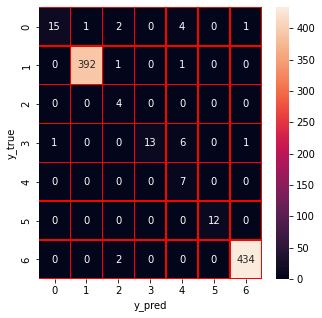

In [ ]:
xg = xgb.XGBClassifier(n_estimators = 10)
xg.fit(X_train,y_train)
xg_score=xg.score(X_test,y_test)
y_predict=xg.predict(X_test)
y_true=y_test
print('Accuracy of XGBoost: '+ str(xg_score))
precision,recall,fscore,none= precision_recall_fscore_support(y_true, y_predict, average='weighted') 
print('Precision of XGBoost: '+(str(precision)))
print('Recall of XGBoost: '+(str(recall)))
print('F1-score of XGBoost: '+(str(fscore)))
print(classification_report(y_true,y_predict))
cm=confusion_matrix(y_true,y_predict)
f,ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

#### Hyperparameter optimization (HPO) of XGBoost using Bayesian optimization with tree-based Parzen estimator (BO-TPE)

In [ ]:
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
from sklearn.model_selection import cross_val_score, StratifiedKFold
def objective(params):
    params = {
        'n_estimators': int(params['n_estimators']), 
        'max_depth': int(params['max_depth']),
        'learning_rate':  abs(float(params['learning_rate'])),

    }
    clf = xgb.XGBClassifier( **params)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    score = accuracy_score(y_test, y_pred)

    return {'loss':-score, 'status': STATUS_OK }

space = {
    'n_estimators': hp.quniform('n_estimators', 10, 100, 5),
    'max_depth': hp.quniform('max_depth', 4, 100, 1),
    'learning_rate': hp.normal('learning_rate', 0.01, 0.9),
}

best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=20)
print("XGBoost: Hyperopt estimated optimum {}".format(best))

100%|██████████| 20/20 [00:33<00:00,  1.66s/it, best loss: -0.9977703455964325]
XGBoost: Hyperopt estimated optimum {'learning_rate': 1.549228315460332, 'max_depth': 28.0, 'n_estimators': 25.0}


Accuracy of XGBoost: 0.9966555183946488
Precision of XGBoost: 0.9971535482429922
Recall of XGBoost: 0.9966555183946488
F1-score of XGBoost: 0.9966788423354465
              precision    recall  f1-score   support

           0       1.00      0.87      0.93        23
           1       1.00      1.00      1.00       394
           2       1.00      1.00      1.00         4
           3       1.00      1.00      1.00        21
           4       0.78      1.00      0.88         7
           5       1.00      1.00      1.00        12
           6       1.00      1.00      1.00       436

    accuracy                           1.00       897
   macro avg       0.97      0.98      0.97       897
weighted avg       1.00      1.00      1.00       897



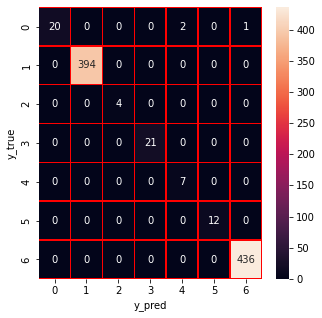

In [ ]:
xg = xgb.XGBClassifier(learning_rate= 0.7340229699980686, n_estimators = 70, max_depth = 14)
xg.fit(X_train,y_train)
xg_score=xg.score(X_test,y_test)
y_predict=xg.predict(X_test)
y_true=y_test
print('Accuracy of XGBoost: '+ str(xg_score))
precision,recall,fscore,none= precision_recall_fscore_support(y_true, y_predict, average='weighted') 
print('Precision of XGBoost: '+(str(precision)))
print('Recall of XGBoost: '+(str(recall)))
print('F1-score of XGBoost: '+(str(fscore)))
print(classification_report(y_true,y_predict))
cm=confusion_matrix(y_true,y_predict)
f,ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

In [ ]:
xg_train=xg.predict(X_train)
xg_test=xg.predict(X_test)

#### Apply RF

Accuracy of RF: 0.9933110367892977
Precision of RF: 0.9943225770575904
Recall of RF: 0.9933110367892977
F1-score of RF: 0.9932690097123109
              precision    recall  f1-score   support

           0       1.00      0.78      0.88        23
           1       0.99      1.00      1.00       394
           2       1.00      1.00      1.00         4
           3       1.00      1.00      1.00        21
           4       0.70      1.00      0.82         7
           5       1.00      1.00      1.00        12
           6       1.00      1.00      1.00       436

    accuracy                           0.99       897
   macro avg       0.96      0.97      0.96       897
weighted avg       0.99      0.99      0.99       897



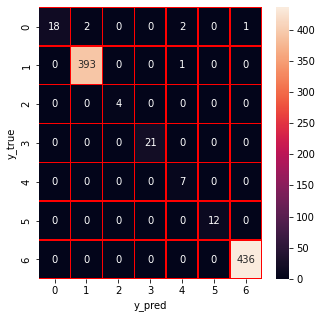

In [ ]:
rf = RandomForestClassifier(random_state = 0)
rf.fit(X_train,y_train) 
rf_score=rf.score(X_test,y_test)
y_predict=rf.predict(X_test)
y_true=y_test
print('Accuracy of RF: '+ str(rf_score))
precision,recall,fscore,none= precision_recall_fscore_support(y_true, y_predict, average='weighted') 
print('Precision of RF: '+(str(precision)))
print('Recall of RF: '+(str(recall)))
print('F1-score of RF: '+(str(fscore)))
print(classification_report(y_true,y_predict))
cm=confusion_matrix(y_true,y_predict)
f,ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

#### Hyperparameter optimization (HPO) of random forest using Bayesian optimization with tree-based Parzen estimator (BO-TPE)

In [ ]:
# Hyperparameter optimization of random forest
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
from sklearn.model_selection import cross_val_score, StratifiedKFold
# Define the objective function
def objective(params):
    params = {
        'n_estimators': int(params['n_estimators']), 
        'max_depth': int(params['max_depth']),
        'max_features': int(params['max_features']),
        "min_samples_split":int(params['min_samples_split']),
        "min_samples_leaf":int(params['min_samples_leaf']),
        "criterion":str(params['criterion'])
    }
    clf = RandomForestClassifier( **params)
    clf.fit(X_train,y_train)
    score=clf.score(X_test,y_test)

    return {'loss':-score, 'status': STATUS_OK }
# Define the hyperparameter configuration space
space = {
    'n_estimators': hp.quniform('n_estimators', 10, 200, 1),
    'max_depth': hp.quniform('max_depth', 5, 50, 1),
    "max_features":hp.quniform('max_features', 1, 20, 1),
    "min_samples_split":hp.quniform('min_samples_split',2,11,1),
    "min_samples_leaf":hp.quniform('min_samples_leaf',1,11,1),
    "criterion":hp.choice('criterion',['gini','entropy'])
}

best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=20)
print("Random Forest: Hyperopt estimated optimum {}".format(best))

100%|██████████| 20/20 [00:29<00:00,  1.46s/it, best loss: -0.9944258639910813]
Random Forest: Hyperopt estimated optimum {'criterion': 1, 'max_depth': 38.0, 'max_features': 14.0, 'min_samples_leaf': 1.0, 'min_samples_split': 4.0, 'n_estimators': 67.0}


Accuracy of RF: 0.9910813823857302
Precision of RF: 0.991472722781799
Recall of RF: 0.9910813823857302
F1-score of RF: 0.9909972761923818
              precision    recall  f1-score   support

           0       0.90      0.78      0.84        23
           1       1.00      0.99      1.00       394
           2       0.80      1.00      0.89         4
           3       1.00      0.95      0.98        21
           4       0.78      1.00      0.88         7
           5       1.00      1.00      1.00        12
           6       1.00      1.00      1.00       436

    accuracy                           0.99       897
   macro avg       0.92      0.96      0.94       897
weighted avg       0.99      0.99      0.99       897



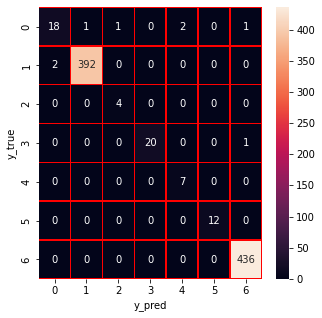

In [ ]:
rf_hpo = RandomForestClassifier(n_estimators = 71, min_samples_leaf = 1, max_depth = 46, min_samples_split = 9, max_features = 20, criterion = 'entropy')
rf_hpo.fit(X_train,y_train)
rf_score=rf_hpo.score(X_test,y_test)
y_predict=rf_hpo.predict(X_test)
y_true=y_test
print('Accuracy of RF: '+ str(rf_score))
precision,recall,fscore,none= precision_recall_fscore_support(y_true, y_predict, average='weighted') 
print('Precision of RF: '+(str(precision)))
print('Recall of RF: '+(str(recall)))
print('F1-score of RF: '+(str(fscore)))
print(classification_report(y_true,y_predict))
cm=confusion_matrix(y_true,y_predict)
f,ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

In [ ]:
rf_train=rf_hpo.predict(X_train)
rf_test=rf_hpo.predict(X_test)

#### Apply DT

Accuracy of DT: 0.987736900780379
Precision of DT: 0.9887729018163801
Recall of DT: 0.987736900780379
F1-score of DT: 0.987931287264197
              precision    recall  f1-score   support

           0       0.82      0.78      0.80        23
           1       1.00      1.00      1.00       394
           2       0.67      1.00      0.80         4
           3       1.00      0.90      0.95        21
           4       0.78      1.00      0.88         7
           5       1.00      1.00      1.00        12
           6       0.99      0.99      0.99       436

    accuracy                           0.99       897
   macro avg       0.89      0.95      0.92       897
weighted avg       0.99      0.99      0.99       897



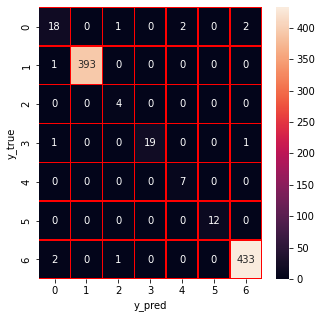

In [ ]:
dt = DecisionTreeClassifier(random_state = 0)
dt.fit(X_train,y_train) 
dt_score=dt.score(X_test,y_test)
y_predict=dt.predict(X_test)
y_true=y_test
print('Accuracy of DT: '+ str(dt_score))
precision,recall,fscore,none= precision_recall_fscore_support(y_true, y_predict, average='weighted') 
print('Precision of DT: '+(str(precision)))
print('Recall of DT: '+(str(recall)))
print('F1-score of DT: '+(str(fscore)))
print(classification_report(y_true,y_predict))
cm=confusion_matrix(y_true,y_predict)
f,ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

#### Hyperparameter optimization (HPO) of decision tree using Bayesian optimization with tree-based Parzen estimator (BO-TPE)


In [ ]:
# Hyperparameter optimization of decision tree
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
from sklearn.model_selection import cross_val_score, StratifiedKFold
# Define the objective function
def objective(params):
    params = {
        'max_depth': int(params['max_depth']),
        'max_features': int(params['max_features']),
        "min_samples_split":int(params['min_samples_split']),
        "min_samples_leaf":int(params['min_samples_leaf']),
        "criterion":str(params['criterion'])
    }
    clf = DecisionTreeClassifier( **params)
    clf.fit(X_train,y_train)
    score=clf.score(X_test,y_test)

    return {'loss':-score, 'status': STATUS_OK }
# Define the hyperparameter configuration space
space = {
    'max_depth': hp.quniform('max_depth', 5, 50, 1),
    "max_features":hp.quniform('max_features', 1, 20, 1),
    "min_samples_split":hp.quniform('min_samples_split',2,11,1),
    "min_samples_leaf":hp.quniform('min_samples_leaf',1,11,1),
    "criterion":hp.choice('criterion',['gini','entropy'])
}

best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=50)
print("Decision tree: Hyperopt estimated optimum {}".format(best))

100%|██████████| 50/50 [00:01<00:00, 26.54it/s, best loss: -0.9933110367892977]
Decision tree: Hyperopt estimated optimum {'criterion': 1, 'max_depth': 30.0, 'max_features': 8.0, 'min_samples_leaf': 1.0, 'min_samples_split': 5.0}


Accuracy of DT: 0.9910813823857302
Precision of DT: 0.9912718923588489
Recall of DT: 0.9910813823857302
F1-score of DT: 0.9909092951317913
              precision    recall  f1-score   support

           0       0.90      0.83      0.86        23
           1       1.00      1.00      1.00       394
           2       0.80      1.00      0.89         4
           3       1.00      0.86      0.92        21
           4       0.88      1.00      0.93         7
           5       1.00      1.00      1.00        12
           6       0.99      1.00      1.00       436

    accuracy                           0.99       897
   macro avg       0.94      0.95      0.94       897
weighted avg       0.99      0.99      0.99       897



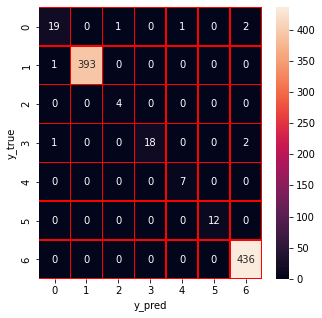

In [ ]:
dt_hpo = DecisionTreeClassifier(min_samples_leaf = 2, max_depth = 47, min_samples_split = 3, max_features = 19, criterion = 'gini')
dt_hpo.fit(X_train,y_train)
dt_score=dt_hpo.score(X_test,y_test)
y_predict=dt_hpo.predict(X_test)
y_true=y_test
print('Accuracy of DT: '+ str(dt_score))
precision,recall,fscore,none= precision_recall_fscore_support(y_true, y_predict, average='weighted') 
print('Precision of DT: '+(str(precision)))
print('Recall of DT: '+(str(recall)))
print('F1-score of DT: '+(str(fscore)))
print(classification_report(y_true,y_predict))
cm=confusion_matrix(y_true,y_predict)
f,ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

In [ ]:
dt_train=dt_hpo.predict(X_train)
dt_test=dt_hpo.predict(X_test)

#### Apply ET

Accuracy of ET: 0.9910813823857302
Precision of ET: 0.9923308261552833
Recall of ET: 0.9910813823857302
F1-score of ET: 0.9909460639395126
              precision    recall  f1-score   support

           0       1.00      0.74      0.85        23
           1       0.99      1.00      1.00       394
           2       0.67      1.00      0.80         4
           3       1.00      1.00      1.00        21
           4       0.78      1.00      0.88         7
           5       1.00      1.00      1.00        12
           6       1.00      1.00      1.00       436

    accuracy                           0.99       897
   macro avg       0.92      0.96      0.93       897
weighted avg       0.99      0.99      0.99       897



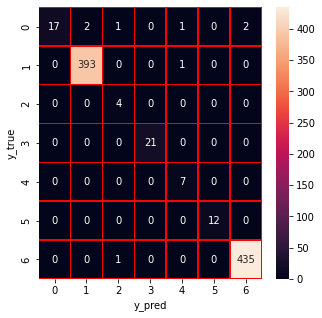

In [ ]:
et = ExtraTreesClassifier(random_state = 0)
et.fit(X_train,y_train) 
et_score=et.score(X_test,y_test)
y_predict=et.predict(X_test)
y_true=y_test
print('Accuracy of ET: '+ str(et_score))
precision,recall,fscore,none= precision_recall_fscore_support(y_true, y_predict, average='weighted') 
print('Precision of ET: '+(str(precision)))
print('Recall of ET: '+(str(recall)))
print('F1-score of ET: '+(str(fscore)))
print(classification_report(y_true,y_predict))
cm=confusion_matrix(y_true,y_predict)
f,ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

#### Hyperparameter optimization (HPO) of extra trees using Bayesian optimization with tree-based Parzen estimator (BO-TPE)

In [ ]:
# Hyperparameter optimization of extra trees
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
from sklearn.model_selection import cross_val_score, StratifiedKFold
# Define the objective function
def objective(params):
    params = {
        'n_estimators': int(params['n_estimators']), 
        'max_depth': int(params['max_depth']),
        'max_features': int(params['max_features']),
        "min_samples_split":int(params['min_samples_split']),
        "min_samples_leaf":int(params['min_samples_leaf']),
        "criterion":str(params['criterion'])
    }
    clf = ExtraTreesClassifier( **params)
    clf.fit(X_train,y_train)
    score=clf.score(X_test,y_test)

    return {'loss':-score, 'status': STATUS_OK }
# Define the hyperparameter configuration space
space = {
    'n_estimators': hp.quniform('n_estimators', 10, 200, 1),
    'max_depth': hp.quniform('max_depth', 5, 50, 1),
    "max_features":hp.quniform('max_features', 1, 20, 1),
    "min_samples_split":hp.quniform('min_samples_split',2,11,1),
    "min_samples_leaf":hp.quniform('min_samples_leaf',1,11,1),
    "criterion":hp.choice('criterion',['gini','entropy'])
}

best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=20)
print("Random Forest: Hyperopt estimated optimum {}".format(best))

100%|██████████| 20/20 [00:07<00:00,  2.77it/s, best loss: -0.9933110367892977]
Random Forest: Hyperopt estimated optimum {'criterion': 0, 'max_depth': 18.0, 'max_features': 18.0, 'min_samples_leaf': 2.0, 'min_samples_split': 3.0, 'n_estimators': 167.0}


Accuracy of ET: 0.992196209587514
Precision of ET: 0.9929315451054581
Recall of ET: 0.992196209587514
F1-score of ET: 0.9920632561849658
              precision    recall  f1-score   support

           0       1.00      0.78      0.88        23
           1       0.99      1.00      0.99       394
           2       0.80      1.00      0.89         4
           3       1.00      1.00      1.00        21
           4       0.78      1.00      0.88         7
           5       1.00      1.00      1.00        12
           6       1.00      1.00      1.00       436

    accuracy                           0.99       897
   macro avg       0.94      0.97      0.95       897
weighted avg       0.99      0.99      0.99       897



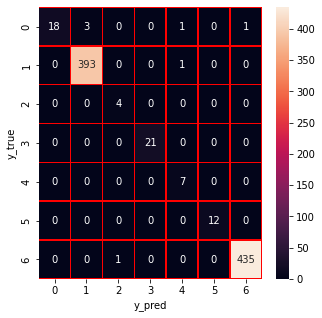

In [ ]:
et_hpo = ExtraTreesClassifier(n_estimators = 53, min_samples_leaf = 1, max_depth = 31, min_samples_split = 5, max_features = 20, criterion = 'entropy')
et_hpo.fit(X_train,y_train) 
et_score=et_hpo.score(X_test,y_test)
y_predict=et_hpo.predict(X_test)
y_true=y_test
print('Accuracy of ET: '+ str(et_score))
precision,recall,fscore,none= precision_recall_fscore_support(y_true, y_predict, average='weighted') 
print('Precision of ET: '+(str(precision)))
print('Recall of ET: '+(str(recall)))
print('F1-score of ET: '+(str(fscore)))
print(classification_report(y_true,y_predict))
cm=confusion_matrix(y_true,y_predict)
f,ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

In [ ]:
et_train=et_hpo.predict(X_train)
et_test=et_hpo.predict(X_test)

### Apply Stacking
The ensemble model that combines the four ML models (DT, RF, ET, XGBoost)

In [ ]:
base_predictions_train = pd.DataFrame( {
    'DecisionTree': dt_train.ravel(),
        'RandomForest': rf_train.ravel(),
     'ExtraTrees': et_train.ravel(),
     'XgBoost': xg_train.ravel(),
    })
base_predictions_train.head(5)

,DecisionTree,RandomForest,ExtraTrees,XgBoost
0,1,1,1,1
1,6,6,6,6
2,1,1,1,1
3,1,1,1,1
4,6,6,6,6


In [ ]:
dt_train=dt_train.reshape(-1, 1)
et_train=et_train.reshape(-1, 1)
rf_train=rf_train.reshape(-1, 1)
xg_train=xg_train.reshape(-1, 1)
dt_test=dt_test.reshape(-1, 1)
et_test=et_test.reshape(-1, 1)
rf_test=rf_test.reshape(-1, 1)
xg_test=xg_test.reshape(-1, 1)

In [ ]:
dt_train.shape

(5542, 1)

In [ ]:
x_train = np.concatenate(( dt_train, et_train, rf_train, xg_train), axis=1)
x_test = np.concatenate(( dt_test, et_test, rf_test, xg_test), axis=1)

Accuracy of Stacking: 0.9966555183946488
Precision of Stacking: 0.9971535482429922
Recall of Stacking: 0.9966555183946488
F1-score of Stacking: 0.9966788423354465
              precision    recall  f1-score   support

           0       1.00      0.87      0.93        23
           1       1.00      1.00      1.00       394
           2       1.00      1.00      1.00         4
           3       1.00      1.00      1.00        21
           4       0.78      1.00      0.88         7
           5       1.00      1.00      1.00        12
           6       1.00      1.00      1.00       436

    accuracy                           1.00       897
   macro avg       0.97      0.98      0.97       897
weighted avg       1.00      1.00      1.00       897



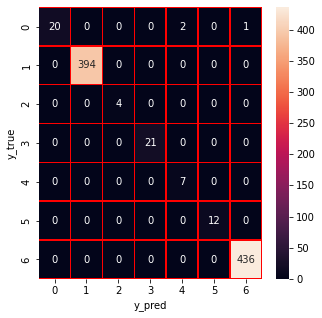

In [ ]:
stk = xgb.XGBClassifier().fit(x_train, y_train)
y_predict=stk.predict(x_test)
y_true=y_test
stk_score=accuracy_score(y_true,y_predict)
print('Accuracy of Stacking: '+ str(stk_score))
precision,recall,fscore,none= precision_recall_fscore_support(y_true, y_predict, average='weighted') 
print('Precision of Stacking: '+(str(precision)))
print('Recall of Stacking: '+(str(recall)))
print('F1-score of Stacking: '+(str(fscore)))
print(classification_report(y_true,y_predict))
cm=confusion_matrix(y_true,y_predict)
f,ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

#### Hyperparameter optimization (HPO) of the stacking ensemble model (XGBoost) using Bayesian optimization with tree-based Parzen estimator (BO-TPE)

In [ ]:
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
from sklearn.model_selection import cross_val_score, StratifiedKFold
def objective(params):
    params = {
        'n_estimators': int(params['n_estimators']), 
        'max_depth': int(params['max_depth']),
        'learning_rate':  abs(float(params['learning_rate'])),

    }
    clf = xgb.XGBClassifier( **params)
    clf.fit(x_train, y_train)
    y_pred = clf.predict(x_test)
    score = accuracy_score(y_test, y_pred)

    return {'loss':-score, 'status': STATUS_OK }

space = {
    'n_estimators': hp.quniform('n_estimators', 10, 100, 5),
    'max_depth': hp.quniform('max_depth', 4, 100, 1),
    'learning_rate': hp.normal('learning_rate', 0.01, 0.9),
}

best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=20)
print("XGBoost: Hyperopt estimated optimum {}".format(best))

100%|██████████| 20/20 [00:06<00:00,  2.93it/s, best loss: -0.9966555183946488]
XGBoost: Hyperopt estimated optimum {'learning_rate': -0.28532101611313154, 'max_depth': 73.0, 'n_estimators': 50.0}


Accuracy of XGBoost: 0.9966555183946488
Precision of XGBoost: 0.9971535482429922
Recall of XGBoost: 0.9966555183946488
F1-score of XGBoost: 0.9966788423354465
              precision    recall  f1-score   support

           0       1.00      0.87      0.93        23
           1       1.00      1.00      1.00       394
           2       1.00      1.00      1.00         4
           3       1.00      1.00      1.00        21
           4       0.78      1.00      0.88         7
           5       1.00      1.00      1.00        12
           6       1.00      1.00      1.00       436

    accuracy                           1.00       897
   macro avg       0.97      0.98      0.97       897
weighted avg       1.00      1.00      1.00       897



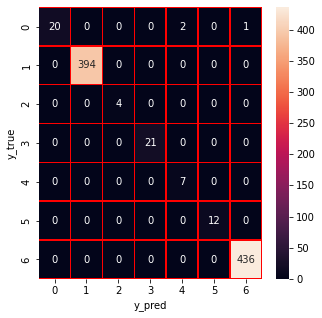

In [ ]:
xg = xgb.XGBClassifier(learning_rate= 0.19229249758051492, n_estimators = 30, max_depth = 36)
xg.fit(x_train,y_train)
xg_score=xg.score(x_test,y_test)
y_predict=xg.predict(x_test)
y_true=y_test
print('Accuracy of XGBoost: '+ str(xg_score))
precision,recall,fscore,none= precision_recall_fscore_support(y_true, y_predict, average='weighted') 
print('Precision of XGBoost: '+(str(precision)))
print('Recall of XGBoost: '+(str(recall)))
print('F1-score of XGBoost: '+(str(fscore)))
print(classification_report(y_true,y_predict))
cm=confusion_matrix(y_true,y_predict)
f,ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

## Anomaly-based IDS

### Generate the port-scan datasets for unknown attack detection

In [ ]:
df=pd.read_csv('CICIDS2017_sample_km.csv')

In [ ]:
df.Label.value_counts()

6    2180
1    1966
0     115
3     106
5      61
4      36
2      19
Name: Label, dtype: int64

In [ ]:
df1 = df[df['Label'] != 5]
df1['Label'][df1['Label'] > 0] = 1
df1.to_csv('CICIDS2017_sample_km_without_portscan.csv',index=0)

In [ ]:
df2 = df[df['Label'] == 5]
df2['Label'][df2['Label'] == 5] = 1
df2.to_csv('CICIDS2017_sample_km_portscan.csv',index=0)

### Read the generated datasets for unknown attack detection

In [ ]:
df1 = pd.read_csv('CICIDS2017_sample_km_without_portscan.csv')
df2 = pd.read_csv('CICIDS2017_sample_km_portscan.csv')

In [ ]:
features = df1.drop(['Label'],axis=1).dtypes[df1.dtypes != 'object'].index
df1[features] = df1[features].apply(
    lambda x: (x - x.mean()) / (x.std()))
df2[features] = df2[features].apply(
    lambda x: (x - x.mean()) / (x.std()))
df1 = df1.fillna(0)
df2 = df2.fillna(0)

In [ ]:
df1.Label.value_counts()

1    4307
0     115
Name: Label, dtype: int64

In [ ]:
df2.Label.value_counts()

1    61
Name: Label, dtype: int64

In [ ]:
df2p=df1[df1['Label']==0]
df2pp=df2p.sample(n=None, frac=1255/18225, replace=False, weights=None, random_state=None, axis=0)
df2=pd.concat([df2, df2pp])

In [ ]:
df2.Label.value_counts()

1    61
0     8
Name: Label, dtype: int64

In [ ]:
df = df1.append(df2)

In [ ]:
X = df.drop(['Label'],axis=1) .values
y = df.iloc[:, -1].values.reshape(-1,1)
y=np.ravel(y)
pd.Series(y).value_counts()

1    4368
0     123
dtype: int64

### Feature engineering (IG, FCBF, and KPCA)

#### Feature selection by information gain (IG)

In [ ]:
from sklearn.feature_selection import mutual_info_classif
importances = mutual_info_classif(X, y)

In [ ]:
# calculate the sum of importance scores
f_list = sorted(zip(map(lambda x: round(x, 4), importances), features), reverse=True)
Sum = 0
fs = []
for i in range(0, len(f_list)):
    Sum = Sum + f_list[i][0]
    fs.append(f_list[i][1])

In [ ]:
# select the important features from top to bottom until the accumulated importance reaches 90%
f_list2 = sorted(zip(map(lambda x: round(x, 4), importances/Sum), features), reverse=True)
Sum2 = 0
fs = []
for i in range(0, len(f_list2)):
    Sum2 = Sum2 + f_list2[i][0]
    fs.append(f_list2[i][1])
    if Sum2>=0.9:
        break        

In [ ]:
X_fs = df[fs].values

In [ ]:
X_fs.shape

(4491, 41)

In [ ]:
X_fs

array([[-1.2401089 , -0.88990682, -0.06764938, ..., -0.03074636,
        -0.18732401, -0.13331258],
       [-1.26036173, -0.88990682, -0.066726  , ..., -0.03998857,
        -0.18732375, -0.1333108 ],
       [-0.61471421, -0.87351978, -0.067623  , ..., -0.04007918,
        -0.0303953 ,  0.04738893],
       ...,
       [-1.26036173, -0.88990682, -0.06733279, ...,  1.50382445,
        -0.18732401, -0.13331258],
       [-1.2401089 , -0.88990682, -0.06796597, ..., -0.03609234,
        -0.18732401, -0.13331258],
       [-1.25460898, -0.86789119, -0.06796597, ..., -0.03745149,
        -0.18732401, -0.13331258]])

#### Feature selection by Fast Correlation Based Filter (FCBF)


In [ ]:
from FCBF_module import FCBF, FCBFK, FCBFiP, get_i
fcbf = FCBFK(k = 20)
#fcbf.fit(X_fs, y)

In [ ]:
X_fss = fcbf.fit_transform(X_fs,y)

In [ ]:
X_fss.shape

(4491, 20)

In [ ]:
X_fss

array([[ 0.81540791,  0.81449068, -0.22569588, ..., -0.07194556,
        -0.23398975, -0.1482151 ],
       [ 8.46257766,  8.46017723,  7.09900009, ..., -0.05893037,
         0.0811276 , -0.13442586],
       [-0.3036901 , -0.30439027, -0.22569588, ..., -0.0263924 ,
         5.16275652,  0.66837508],
       ...,
       [ 8.64909399,  8.64665739,  3.36191031, ..., -0.06543796,
        -0.01843716, -0.14483814],
       [-0.3036901 , -0.30439027, -0.22569588, ..., -0.07194556,
        -0.26478298, -0.1482151 ],
       [-0.3036901 , -0.30439027, -0.22569588, ..., -0.06543796,
        -0.26478298, -0.1482151 ]])

####  kernel principal component analysis (KPCA)

In [ ]:
from sklearn.decomposition import KernelPCA
kpca = KernelPCA(n_components = 10, kernel = 'rbf')
kpca.fit(X_fss, y)
X_kpca = kpca.transform(X_fss)

# from sklearn.decomposition import PCA
# kpca = PCA(n_components = 10)
# kpca.fit(X_fss, y)
# X_kpca = kpca.transform(X_fss)

### Train-test split after feature selection

In [ ]:
X_train = X_kpca[:len(df1)]
y_train = y[:len(df1)]
X_test = X_kpca[len(df1):]
y_test = y[len(df1):]

### Solve class-imbalance by SMOTE

In [ ]:
pd.Series(y_train).value_counts()

1    4307
0     115
dtype: int64

In [ ]:
from imblearn.over_sampling import SMOTE
smote=SMOTE(n_jobs=-1,sampling_strategy={1:18225})
X_train, y_train = smote.fit_resample(X_train, y_train)

In [ ]:
pd.Series(y_train).value_counts()

1    18225
0      115
dtype: int64

In [ ]:
pd.Series(y_test).value_counts()

1    61
0     8
dtype: int64

### Apply the cluster labeling (CL) k-means method

In [ ]:
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN,MeanShift
from sklearn.cluster import SpectralClustering,AgglomerativeClustering,AffinityPropagation,Birch,MiniBatchKMeans,MeanShift 
from sklearn.mixture import GaussianMixture, BayesianGaussianMixture
from sklearn.metrics import classification_report
from sklearn import metrics

In [ ]:
def CL_kmeans(X_train, X_test, y_train, y_test,n,b=100):
    km_cluster = MiniBatchKMeans(n_clusters=n,batch_size=b)
    result = km_cluster.fit_predict(X_train)
    result2 = km_cluster.predict(X_test)

    count=0
    a=np.zeros(n)
    b=np.zeros(n)
    for v in range(0,n):
        for i in range(0,len(y_train)):
            if result[i]==v:
                if y_train[i]==1:
                    a[v]=a[v]+1
                else:
                    b[v]=b[v]+1
    list1=[]
    list2=[]
    for v in range(0,n):
        if a[v]<=b[v]:
            list1.append(v)
        else: 
            list2.append(v)
    for v in range(0,len(y_test)):
        if result2[v] in list1:
            result2[v]=0
        elif result2[v] in list2:
            result2[v]=1
        else:
            print("-1")
    print(classification_report(y_test, result2))
    cm=confusion_matrix(y_test,result2)
    acc=metrics.accuracy_score(y_test,result2)
    print(str(acc))
    print(cm)

In [ ]:
CL_kmeans(X_train, X_test, y_train, y_test, 8)

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         8
           1       0.88      1.00      0.94        61

    accuracy                           0.88        69
   macro avg       0.44      0.50      0.47        69
weighted avg       0.78      0.88      0.83        69

0.8840579710144928
[[ 0  8]
 [ 0 61]]


### Hyperparameter optimization of CL-k-means
Tune "k"

In [ ]:
!pip install scikit_optimize

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 100 kB 5.5 MB/s 


In [ ]:
#Hyperparameter optimization by BO-GP
from skopt.space import Real, Integer
from skopt.utils import use_named_args
from sklearn import metrics

space  = [Integer(2, 50, name='n_clusters')]
@use_named_args(space)
def objective(**params):
    km_cluster = MiniBatchKMeans(batch_size=100, **params)
    n=params['n_clusters']
    
    result = km_cluster.fit_predict(X_train)
    result2 = km_cluster.predict(X_test)

    count=0
    a=np.zeros(n)
    b=np.zeros(n)
    for v in range(0,n):
        for i in range(0,len(y_train)):
            if result[i]==v:
                if y_train[i]==1:
                    a[v]=a[v]+1
                else:
                    b[v]=b[v]+1
    list1=[]
    list2=[]
    for v in range(0,n):
        if a[v]<=b[v]:
            list1.append(v)
        else: 
            list2.append(v)
    for v in range(0,len(y_test)):
        if result2[v] in list1:
            result2[v]=0
        elif result2[v] in list2:
            result2[v]=1
        else:
            print("-1")
    cm=metrics.accuracy_score(y_test,result2)
    print(str(n)+" "+str(cm))
    return (1-cm)
from skopt import gp_minimize
import time
t1=time.time()
res_gp = gp_minimize(objective, space, n_calls=20, random_state=0)
t2=time.time()
print(t2-t1)
print("Best score=%.4f" % (1-res_gp.fun))
print("""Best parameters: n_clusters=%d""" % (res_gp.x[0]))

30 0.8840579710144928
43 0.8840579710144928
43 0.9420289855072463
43 0.8985507246376812
32 0.8840579710144928
20 0.8840579710144928
16 0.8840579710144928
5 0.8840579710144928
15 0.8840579710144928
25 0.8840579710144928
50 0.8985507246376812
50 0.9420289855072463
50 0.8985507246376812
2 0.8840579710144928
50 0.8985507246376812
50 0.927536231884058
50 0.9420289855072463
50 0.927536231884058
50 0.8840579710144928
2 0.8840579710144928
53.107017040252686
Best score=0.9420
Best parameters: n_clusters=43


In [ ]:
#Hyperparameter optimization by BO-TPE
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.cluster import MiniBatchKMeans
from sklearn import metrics

def objective(params):
    params = {
        'n_clusters': int(params['n_clusters']), 
    }
    km_cluster = MiniBatchKMeans(batch_size=100, **params)
    n=params['n_clusters']
    
    result = km_cluster.fit_predict(X_train)
    result2 = km_cluster.predict(X_test)

    count=0
    a=np.zeros(n)
    b=np.zeros(n)
    for v in range(0,n):
        for i in range(0,len(y_train)):
            if result[i]==v:
                if y_train[i]==1:
                    a[v]=a[v]+1
                else:
                    b[v]=b[v]+1
    list1=[]
    list2=[]
    for v in range(0,n):
        if a[v]<=b[v]:
            list1.append(v)
        else: 
            list2.append(v)
    for v in range(0,len(y_test)):
        if result2[v] in list1:
            result2[v]=0
        elif result2[v] in list2:
            result2[v]=1
        else:
            print("-1")
    score=metrics.accuracy_score(y_test,result2)
    print(str(params['n_clusters'])+" "+str(score))
    return {'loss':1-score, 'status': STATUS_OK }
space = {
    'n_clusters': hp.quniform('n_clusters', 2, 50, 1),
}

best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=20)
print("Random Forest: Hyperopt estimated optimum {}".format(best))

13 0.8840579710144928
15 0.8840579710144928
36 0.9420289855072463
28 0.927536231884058
21 0.8840579710144928
24 0.8840579710144928
38 0.8840579710144928
46 0.8840579710144928
9 0.8840579710144928
36 0.927536231884058
37 0.8840579710144928
47 0.9420289855072463
31 0.8840579710144928
35 0.8840579710144928
20 0.8840579710144928
50 0.8840579710144928
24 0.8840579710144928
3 0.8840579710144928
6 0.8840579710144928
39 0.8840579710144928
100%|██████████| 20/20 [00:40<00:00,  2.01s/it, best loss: 0.05797101449275366]
Random Forest: Hyperopt estimated optimum {'n_clusters': 36.0}


In [ ]:
CL_kmeans(X_train, X_test, y_train, y_test, 16)

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         8
           1       0.88      1.00      0.94        61

    accuracy                           0.88        69
   macro avg       0.44      0.50      0.47        69
weighted avg       0.78      0.88      0.83        69

0.8840579710144928
[[ 0  8]
 [ 0 61]]
